In [1]:
from netCDF4 import Dataset
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import glob,os,pdb
import datetime as dt
import pandas as pd
import scipy.stats
%matplotlib ipympl
plt.close('all')

In [38]:
def calculate_bad_pixels(mean_dark,std_dark,bp=None):
    dead = np.zeros(mean_dark.shape)
    hot = dead.copy()
    cold = dead.copy()
    high_std = dead.copy()
    if bp is None:
        bp = np.zeros(dead.shape)
    dead[np.logical_and(std_dark < 1,bp<1)] = 1  # Dead Pixels
    dead[std_dark.mask] = 0
    
    cold[np.logical_and(mean_dark < 1000, std_dark < 1,bp<1)] = 1  # COLD Pixels
    cold[std_dark.mask] = 0
    
    hot[np.logical_and(mean_dark > 3000, std_dark < 1,bp<1)] = 1  # HOT Pixels
    hot[std_dark.mask] = 0
    
    high_std[np.logical_and(std_dark > 5 * np.nanmean(std_dark),bp<1)] = 1
    high_std[std_dark.mask] = 0

    return {'dead':dead[:],'cold':cold[:],'hot':hot[:],'noisy':high_std[:]}

def denoise_replace_mask(dn=None,thresh=1.5,pf_bp=None,filter='median'):
    bp_c = calculate_bad_pixels(dn.mean(0),dn.std(0),bp=pf_bp)
    y,x = np.where(bp_c['noisy'] == 1)

    new_mask = np.zeros(dn.shape)
    if filter == 'mean':
        new_mask[:,y,x] = np.array([dn[:,yy,xx] > np.nanmean(dn[:,yy,xx],0) + thresh*np.nanstd(dn[:,yy,xx],0) for xx,yy in zip(x,y)]).T
    elif filter == 'median':
        new_mask[:,y,x] = np.array([dn[:,yy,xx] > np.nanmedian(dn[:,yy,xx],0) + thresh*scipy.stats.iqr(dn[:,yy,xx]) for xx,yy in zip(x,y)]).T

    denoised_dark = dn.copy()
    denoised_dark.mask[:,y,x] = np.logical_or(denoised_dark.mask[:,y,x],new_mask[:,y,x])

    new_bp = calculate_bad_pixels(denoised_dark.mean(0),denoised_dark.std(0),bp=pf_bp)
    return bp_c,new_bp,denoised_dark

def denoise_replace_values(dn=None,thresh=1.5,pf_bp=None,filter='mean'):
    bp_c = calculate_bad_pixels(dn.mean(0),dn.std(0),bp=pf_bp)
    y,x = np.where(bp_c['noisy'] == 1)

    new_vals = dn.copy()
    
    if filter == 'mean':
        try:
            for xx,yy in zip(x,y):
                bad_inds = np.where(dn[:,yy,xx] > np.nanmean(dn[:,yy,xx],0) + thresh*np.nanstd(dn[:,yy,xx],0))[0]
                good_inds = np.where(dn[:,yy,xx] <= np.nanmean(dn[:,yy,xx],0) + thresh*np.nanstd(dn[:,yy,xx],0))[0]
                new_vals[bad_inds,yy,xx] = np.nanmean(dn[good_inds,yy,xx],0)
        except:
            pdb.set_trace()
    elif filter == 'median':
        for xx,yy in zip(x,y):
            inds = np.where(dn[:,yy,xx] > np.nanmedian(dn[:,yy,xx],0) + thresh*scipy.stats.iqr(dn[:,yy,xx]))[0]
            new_vals[inds,yy,xx] = np.nan
            new_vals[inds,yy,xx] = np.nanmedian(new_vals[:,yy,xx],0)
            
    denoised_dark = new_vals.copy()
    denoised_dark.mask = dn.mask.copy()
    #denoised_dark.mask[:,y,x] = np.logical_or(denoised_dark.mask[:,y,x],new_mask[:,y,x])

    new_bp = calculate_bad_pixels(denoised_dark.mean(0),denoised_dark.std(0),bp=pf_bp)
    return bp_c,new_bp,denoised_dark

In [3]:
os.chdir('/media/sata/methanesat/darks/')
#ch4_files = np.array(sorted(list(Path('./mean_darks/').rglob('*CH4*.nc'))))
#o2_files = np.array(sorted(list(Path('./mean_darks/').rglob('*O2*.nc'))))
ch4_bp = Dataset('../level1a_calibration_MSAT_20250722.0.0_CH4_BadPixelMap_CH4_20250722.nc','r')['BadPixelMap'][:] 
o2_bp = Dataset('../level1a_calibration_MSAT_20250722.0.0_O2_BadPixelMap_O2_20250722.nc','r')['BadPixelMap'][:] 
ch4_l0_files = list(Path('./2024/').rglob('*CH4*.nc'))
ch4_l0_files.extend(list(Path('./2025/').rglob('*CH4*.nc')))
ch4_l0_files = sorted(ch4_l0_files)
ch4_l0_files = np.array(ch4_l0_files)
ch4_l0_collect_id = np.array([str(fi).split('/')[-1].split('_')[5] for fi in ch4_l0_files])

o2_l0_files = list(Path('./2024/').rglob('*O2*.nc'))
o2_l0_files.extend(list(Path('./2025/').rglob('*O2*.nc')))
o2_l0_files = sorted(o2_l0_files)
o2_l0_files = np.array(o2_l0_files)
o2_l0_collect_id = np.array([str(fi).split('/')[-1].split('_')[5] for fi in o2_l0_files])

ch4_nframes = np.array([len(Dataset(fi).dimensions['frame_number']) for fi in ch4_l0_files])
o2_nframes = np.array([len(Dataset(fi).dimensions['frame_number']) for fi in o2_l0_files])


## Compute and save out of family collects

In [5]:
bp_types = ['cold','dead','hot','noisy']
o2 = np.load('o2_bp.pkl.npy',allow_pickle=True).item()
for tp in bp_types:
    o2[tp+'_total'] = o2[tp][:,0].sum(1)
    del o2[tp]
    
o2_noisy_med = np.median(o2['noisy_total'])
o2_iqr = scipy.stats.scoreatpercentile(o2['noisy_total'],75)-scipy.stats.scoreatpercentile(o2['noisy_total'],25)

noisy_o2_inds = np.array(np.where(np.abs(o2['noisy_total']-o2_noisy_med) > 5*67./50.*o2_iqr)).flatten()
noisy_o2_files = o2_l0_files[noisy_o2_inds]
noisy_o2_total = o2['noisy_total'][noisy_o2_inds]
noisy_o2_collects = np.array([str(fi).split('/')[-1].split('_')[5].split('.')[0] for fi in noisy_o2_files])
with open('noisy_o2_id','w') as f:
    for c in noisy_o2_files:
        f.write(str(c)+'\n')

ch4 = np.load('ch4_bp.pkl.npy',allow_pickle=True).item()
for tp in bp_types:
    ch4[tp+'_total'] = ch4[tp][:,0].sum(1)
    del ch4[tp]
ch4_noisy_med = np.median(ch4['noisy_total'])
ch4_iqr = scipy.stats.scoreatpercentile(ch4['noisy_total'],75)-scipy.stats.scoreatpercentile(ch4['noisy_total'],25)

noisy_ch4_inds = np.array(np.where(np.abs(ch4['noisy_total']-ch4_noisy_med) > 5*67./50*ch4_iqr)).flatten()
noisy_ch4_files = ch4_l0_files[noisy_ch4_inds]
noisy_ch4_total = ch4['noisy_total'][noisy_ch4_inds]
noisy_ch4_collects = np.array([str(fi).split('/')[-1].split('_')[5].split('.')[0] for fi in noisy_ch4_files])
with open('noisy_ch4_id','w') as f:
    for c in noisy_ch4_files:
        f.write(str(c)+'\n')

In [6]:
ch4_sort_inds = np.array(np.argsort(noisy_ch4_total))
o2_sort_inds = np.array(np.argsort(noisy_o2_total))
print('CH4 Noisy Files Highest to Lowest')
for i in ch4_sort_inds[-1::-1][:10]:
    print(f'{noisy_ch4_total[i]}: {noisy_ch4_files[i]}')
print('=====================================')
print('O2 Noisy Files Highest to Lowest')
for i in o2_sort_inds[-1::-1][:10]:
    print(f'{noisy_o2_total[i]}: {noisy_o2_files[i]}')


CH4 Noisy Files Highest to Lowest
142227.0: 2024/09/01/00F20001/po-2075/MethaneSAT_L0_CH4_Dark_0_00F20001.nc
21534.0: 2024/11/01/037C0001/202411052049_po-2207/MethaneSAT_L0_CH4_Dark_0_037C0001.nc
13201.0: 2024/10/27/034E0001/202411022044_po-2197/MethaneSAT_L0_CH4_Dark_0_034E0001.nc
12018.0: 2024/09/12/014A0001/202409171319_po-2103/MethaneSAT_L0_CH4_Dark_0_014A0001.nc
5650.0: 2025/03/06/080F0001/202503091957_po-2435/MethaneSAT_L0_CH4_Dark_0_080F0001.nc
5650.0: 2025/03/06/080F0001/202503101733_po-2435/MethaneSAT_L0_CH4_Dark_0_080F0001.nc
5590.0: 2024/12/13/04A40001/202412162103_po-2260/MethaneSAT_L0_CH4_Dark_0_04A40001.nc
5584.0: 2025/01/14/06400001/202501162058_po-2321/MethaneSAT_L0_CH4_Dark_0_06400001.nc
5541.0: 2024/11/24/04900001/202411272202_po-2251/MethaneSAT_L0_CH4_Dark_0_04900001.nc
5516.0: 2024/12/29/056F0001/202412312136_po-2276/MethaneSAT_L0_CH4_Dark_0_056F0001.nc
O2 Noisy Files Highest to Lowest
141856.0: 2024/09/01/00F20001/po-2075/MethaneSAT_L0_O2_Dark_0_00F20001.nc
24117.0

0 03BA0001
0 03BA0001


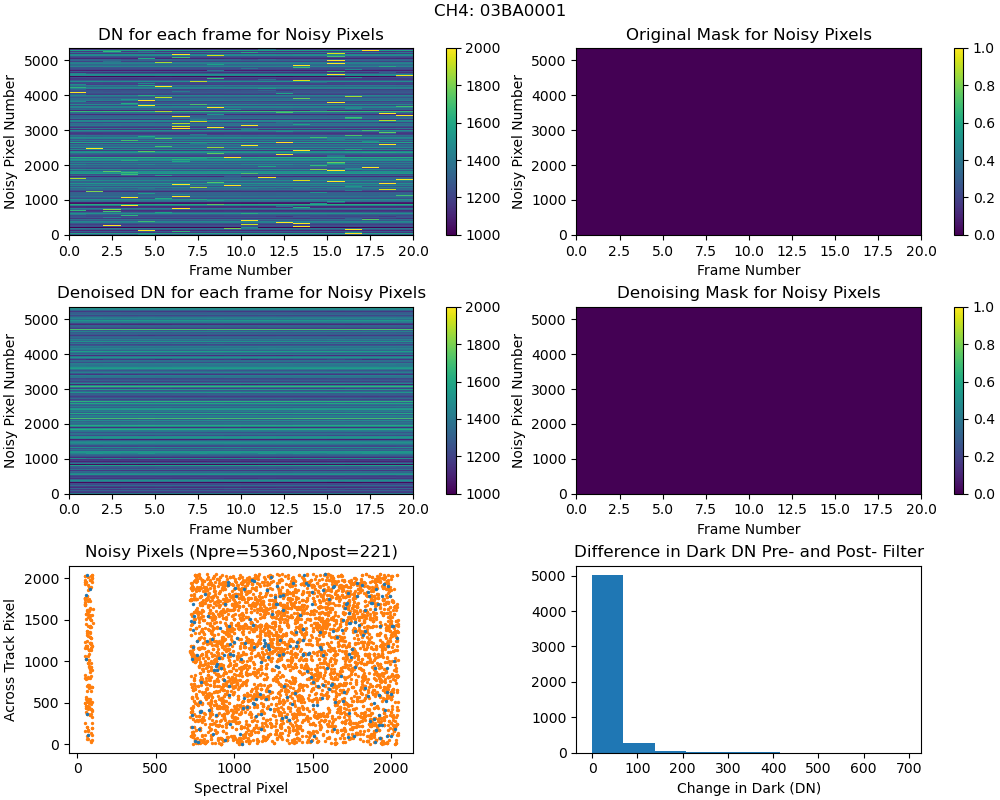

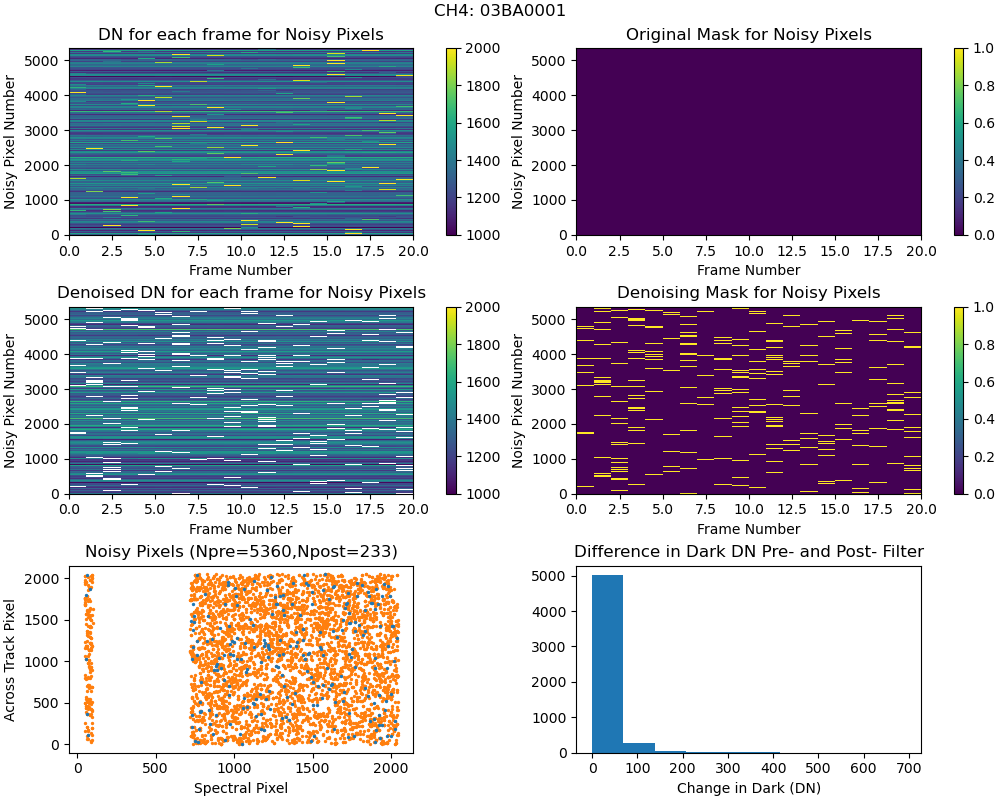

In [57]:
for ifi,fname in enumerate(noisy_ch4_files[10:11]):
    collect_id = str(fname).split('/')[3]
    print(f'{ifi} {collect_id}')
    dn = Dataset(fname)['Frame/PixelData'][:]
    bp_c,new_bp,denoised_dn = denoise_replace_values(dn,pf_bp=ch4_bp)
        
    plt.close('all')
    fig,axs = plt.subplots(3,2,figsize=(10,8),layout='constrained')
    ax = axs[0,0]
    y,x = np.where(bp_c['noisy'])
    g = ax.pcolormesh(dn[:,y,x].T,vmin=1000,vmax=2000); 
    plt.colorbar(g,ax=ax)
    ax.set_title('DN for each frame for Noisy Pixels')
    ax.set_ylabel('Noisy Pixel Number')
    ax.set_xlabel('Frame Number')

    ax = axs[0,1]
    g = ax.pcolormesh(dn.mask[:,y,x].T)#,vmin=1000,vmax=2000);
    plt.colorbar(g,ax=ax)
    ax.set_title('Original Mask for Noisy Pixels')
    ax.set_ylabel('Noisy Pixel Number')
    ax.set_xlabel('Frame Number')

    ax = axs[1,0]
    g = ax.pcolormesh(denoised_dn[:,y,x].T,vmin=1000,vmax=2000); 
    plt.colorbar(g,ax=ax)
    ax.set_title('Denoised DN for each frame for Noisy Pixels')
    ax.set_ylabel('Noisy Pixel Number')
    ax.set_xlabel('Frame Number')

    ax = axs[1,1]
    g = ax.pcolormesh(denoised_dn.mask[:,y,x].T);
    plt.colorbar(g,ax=ax)
    ax.set_title('Denoising Mask for Noisy Pixels')
    ax.set_ylabel('Noisy Pixel Number')
    ax.set_xlabel('Frame Number')
    
    ax = axs[2,0]
    y,x = np.where(bp_c['noisy'])
    g = ax.scatter(x,y,c='tab:orange',s=2);
    y,x = np.where(new_bp['noisy'])
    g = ax.scatter(x,y,c='tab:blue',s=2);
    ax.set_title(f'Noisy Pixels (Npre={int(bp_c["noisy"].sum())},Npost={int(new_bp["noisy"].sum())})')
    ax.set_ylabel('Across Track Pixel')
    ax.set_xlabel('Spectral Pixel')

    ax = axs[2,1]
    y,x = np.where(bp_c['noisy'])
    ax.hist(dn[:,y,x].mean(0)-denoised_dn[:,y,x].mean(0))#,np.arange(len(y)))
    ax.set_title('Difference in Dark DN Pre- and Post- Filter')
    ax.set_xlabel('Change in Dark (DN)')
    #ax.set_ylabel('Noisy Pixel Number')

    fig.suptitle(f'CH4: {collect_id}')
    fig.savefig(f'figs/bad_pixel_maps/outlier_drops/ch4/ch4_{collect_id}_noisy_panel_val_replace.png')

    collect_id = str(fname).split('/')[3]
    print(f'{ifi} {collect_id}')
    dn = Dataset(fname)['Frame/PixelData'][:]
    bp_c,new_bp,denoised_dn = denoise_replace_mask(dn,pf_bp=ch4_bp)
        
    fig,axs = plt.subplots(3,2,figsize=(10,8),layout='constrained')
    ax = axs[0,0]
    y,x = np.where(bp_c['noisy'])
    g = ax.pcolormesh(dn[:,y,x].T,vmin=1000,vmax=2000); 
    plt.colorbar(g,ax=ax)
    ax.set_title('DN for each frame for Noisy Pixels')
    ax.set_ylabel('Noisy Pixel Number')
    ax.set_xlabel('Frame Number')

    ax = axs[0,1]
    g = ax.pcolormesh(dn.mask[:,y,x].T)#,vmin=1000,vmax=2000);
    plt.colorbar(g,ax=ax)
    ax.set_title('Original Mask for Noisy Pixels')
    ax.set_ylabel('Noisy Pixel Number')
    ax.set_xlabel('Frame Number')

    ax = axs[1,0]
    g = ax.pcolormesh(denoised_dn[:,y,x].T,vmin=1000,vmax=2000); 
    plt.colorbar(g,ax=ax)
    ax.set_title('Denoised DN for each frame for Noisy Pixels')
    ax.set_ylabel('Noisy Pixel Number')
    ax.set_xlabel('Frame Number')

    ax = axs[1,1]
    g = ax.pcolormesh(denoised_dn.mask[:,y,x].T);
    plt.colorbar(g,ax=ax)
    ax.set_title('Denoising Mask for Noisy Pixels')
    ax.set_ylabel('Noisy Pixel Number')
    ax.set_xlabel('Frame Number')
    
    ax = axs[2,0]
    y,x = np.where(bp_c['noisy'])
    g = ax.scatter(x,y,c='tab:orange',s=2);
    y,x = np.where(new_bp['noisy'])
    g = ax.scatter(x,y,c='tab:blue',s=2);
    ax.set_title(f'Noisy Pixels (Npre={int(bp_c["noisy"].sum())},Npost={int(new_bp["noisy"].sum())})')
    ax.set_ylabel('Across Track Pixel')
    ax.set_xlabel('Spectral Pixel')

    ax = axs[2,1]
    y,x = np.where(bp_c['noisy'])
    ax.hist(dn[:,y,x].mean(0)-denoised_dn[:,y,x].mean(0))#,np.arange(len(y)))
    ax.set_title('Difference in Dark DN Pre- and Post- Filter')
    ax.set_xlabel('Change in Dark (DN)')
    #ax.set_ylabel('Noisy Pixel Number')

    fig.suptitle(f'CH4: {collect_id}')
    fig.savefig(f'figs/bad_pixel_maps/outlier_drops/ch4/ch4_{collect_id}_noisy_panel_mask_replace.png')

In [48]:
dn = Dataset(noisy_ch4_files[10])['Frame/PixelData'][:]
bp_c,new_bp_val,denoised_dn_val = denoise_replace_values(dn,pf_bp=ch4_bp)
bp_c,new_bp_mask,denoised_dn_mask = denoise_replace_mask(dn,pf_bp=ch4_bp)

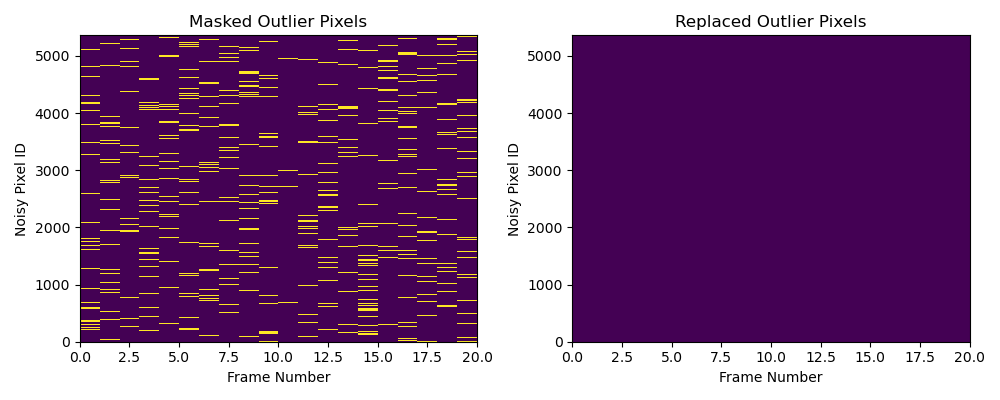

In [55]:
plt.close('all')
fig,axs = plt.subplots(1,2,figsize=(10,4))
y,x = np.where(bp_c['noisy'])
ax = axs[0]
g = ax.pcolormesh(denoised_dn_mask.mask[:,y,x].T,vmin=0,vmax=1); 
ax.set_title('Masked Outlier Pixels') 
ax.set_xlabel('Frame Number')
ax.set_ylabel('Noisy Pixel ID')

ax = axs[1]
y,x = np.where(bp_c['noisy'])
g = plt.pcolormesh(denoised_dn_val.mask[:,y,x].T,vmin=0,vmax=1); 
ax.set_title('Replaced Outlier Pixels') 
ax.set_xlabel('Frame Number')
ax.set_ylabel('Noisy Pixel ID')

fig.tight_layout()

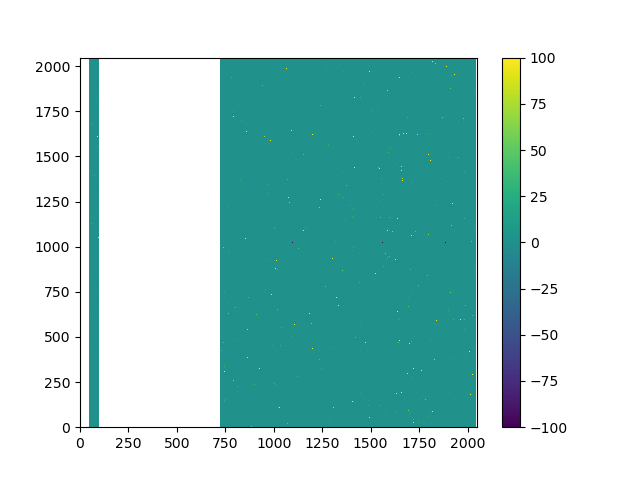

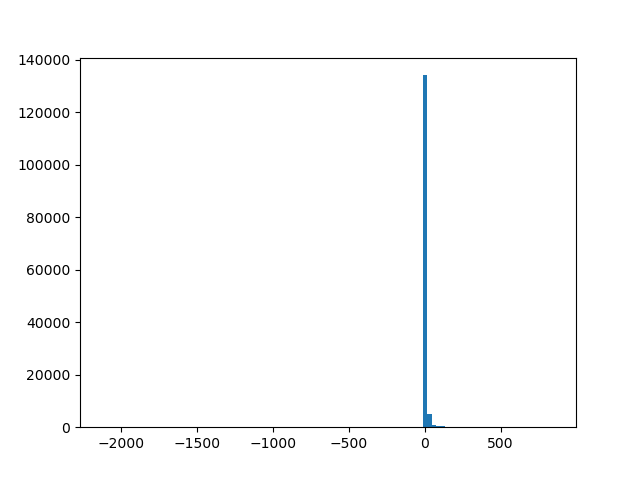

In [35]:
plt.close('all')

dn_val_dk = np.nanmean(denoised_dn_val,0)
dn_mask_dk = np.nanmean(denoised_dn_mask,0)
y,x = np.where(bp_c['noisy'])
plt.figure(); plt.pcolormesh(dn_val_dk-dn_mask_dk,vmin=-100,vmax=100); plt.colorbar()
plt.figure(); plt.hist((dn_val_dk-dn_mask_dk)[y,x].flatten(),bins=100);

In [34]:
(dn_val_dk-dn_mask_dk)[y,x].shape

(142227,)

In [32]:
dn_mask_dk.shape

(2048, 2048)

In [22]:
plt.figure()
plt.hist((dn_mask_dk-dn_val_dk)

-0.17098468895137223

0 03BA0001


/home/sean/miniconda3/envs/mpl/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


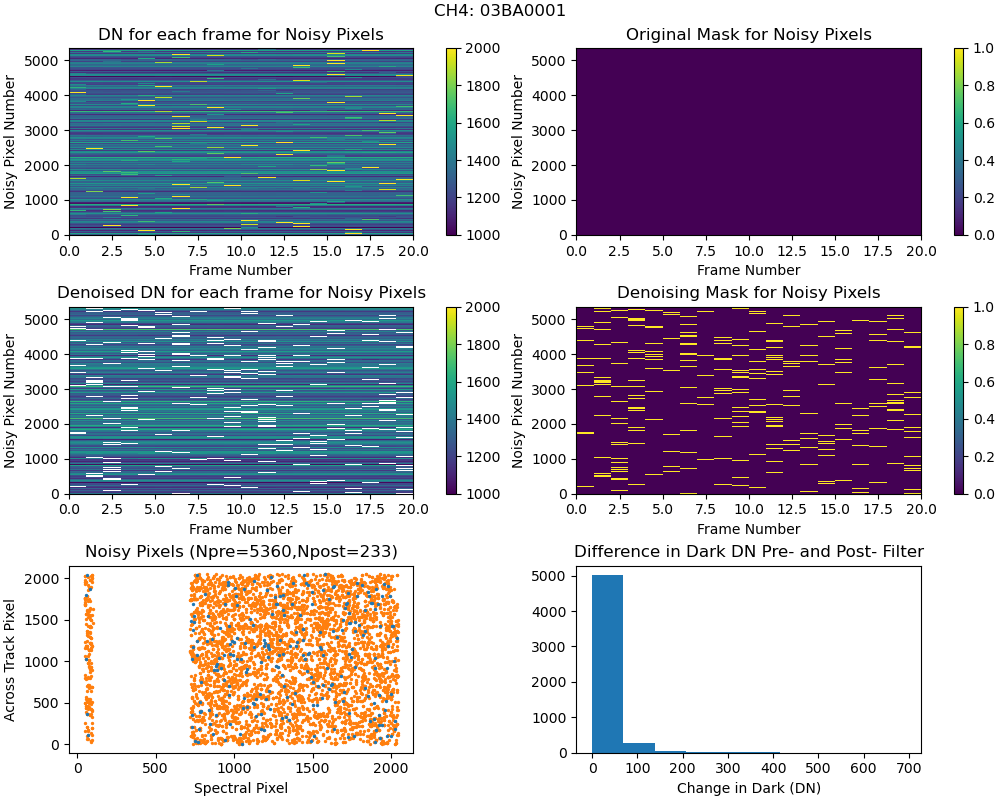

In [37]:
for ifi,fname in enumerate(noisy_ch4_files[10:11]):
    collect_id = str(fname).split('/')[3]
    print(f'{ifi} {collect_id}')
    dn = Dataset(fname)['Frame/PixelData'][:]
    bp_c,new_bp,denoised_dn = denoise_replace_mask(dn,pf_bp=ch4_bp)
        
    plt.close('all')
    fig,axs = plt.subplots(3,2,figsize=(10,8),layout='constrained')
    ax = axs[0,0]
    y,x = np.where(bp_c['noisy'])
    g = ax.pcolormesh(dn[:,y,x].T,vmin=1000,vmax=2000); 
    plt.colorbar(g,ax=ax)
    ax.set_title('DN for each frame for Noisy Pixels')
    ax.set_ylabel('Noisy Pixel Number')
    ax.set_xlabel('Frame Number')

    ax = axs[0,1]
    g = ax.pcolormesh(dn.mask[:,y,x].T)#,vmin=1000,vmax=2000);
    plt.colorbar(g,ax=ax)
    ax.set_title('Original Mask for Noisy Pixels')
    ax.set_ylabel('Noisy Pixel Number')
    ax.set_xlabel('Frame Number')

    ax = axs[1,0]
    g = ax.pcolormesh(denoised_dn[:,y,x].T,vmin=1000,vmax=2000); 
    plt.colorbar(g,ax=ax)
    ax.set_title('Denoised DN for each frame for Noisy Pixels')
    ax.set_ylabel('Noisy Pixel Number')
    ax.set_xlabel('Frame Number')

    ax = axs[1,1]
    g = ax.pcolormesh(denoised_dn.mask[:,y,x].T);
    plt.colorbar(g,ax=ax)
    ax.set_title('Denoising Mask for Noisy Pixels')
    ax.set_ylabel('Noisy Pixel Number')
    ax.set_xlabel('Frame Number')
    
    ax = axs[2,0]
    y,x = np.where(bp_c['noisy'])
    g = ax.scatter(x,y,c='tab:orange',s=2);
    y,x = np.where(new_bp['noisy'])
    g = ax.scatter(x,y,c='tab:blue',s=2);
    ax.set_title(f'Noisy Pixels (Npre={int(bp_c["noisy"].sum())},Npost={int(new_bp["noisy"].sum())})')
    ax.set_ylabel('Across Track Pixel')
    ax.set_xlabel('Spectral Pixel')

    ax = axs[2,1]
    y,x = np.where(bp_c['noisy'])
    ax.hist(dn[:,y,x].mean(0)-denoised_dn[:,y,x].mean(0))#,np.arange(len(y)))
    ax.set_title('Difference in Dark DN Pre- and Post- Filter')
    ax.set_xlabel('Change in Dark (DN)')
    #ax.set_ylabel('Noisy Pixel Number')

    fig.suptitle(f'CH4: {collect_id}')
    fig.savefig(f'figs/bad_pixel_maps/outlier_drops/ch4/ch4_{collect_id}_noisy_panel_val_replace.png')


In [ ]:
for fname in noisy_o2_files[10:11]:
    collect_id = str(fname).split('/')[3]
    dn = Dataset(fname)['Frame/PixelData'][:]
    bp_c,new_bp = denoise(dn,pf_bp=o2_bp)
    
    plt.close('all')
    fig,axs = plt.subplots(2,2,figsize=(10,8),layout='constrained')
    ax = axs[0,0]
    g = ax.pcolormesh(noisy_dn,vmin=1000,vmax=2000); plt.colorbar(g,ax=ax)
    ax.set_title('DN for each frame for Noisy Pixels')
    ax.set_ylabel('Pixel Number')
    ax.set_xlabel('Frame Number')

    ax = axs[0,1]
    g = ax.pcolormesh(noisy_dn_filter[:]);
    plt.colorbar(g,ax=ax)
    ax.set_title('3$\sigma$ Mask (20 Frame Mean and $\sigma$)')
    ax.set_ylabel('Pixel Number')
    ax.set_xlabel('Frame Number')

    ax = axs[1,0]
    y,x = np.where(bp_c['noisy'])
    g = ax.scatter(x,y,c='tab:orange');
    ax.set_title(f'Noisy Pixels Pre-Filtering (N={int(bp_c["noisy"].sum())})')
    ax.set_ylabel('Across Track Pixel')
    ax.set_xlabel('Spectral Pixel')

    ax = axs[1,1]
    y,x = np.where(new_bp['noisy'])
    g = ax.scatter(x,y,c='tab:orange');
    ax.set_title(f'Noisy Pixels Post-Filtering (N={int(new_bp["noisy"].sum())})')
    ax.set_ylabel('Across Track Pixel')
    ax.set_xlabel('Spectral Pixel')

    fig.suptitle(fi)
    fig.savefig(f'figs/bad_pixel_maps/outlier_drops/o2/o2_{collect_id}_noisy_panel.png')



In [ ]:
pre_fname = open('noisy_ch4_id').readlines()[0].rstrip('\n')
post_fname = f'denoise/{pre_fname}'

pre_dn = Dataset(pre_fname,'r')['Frame/PixelData'][:]
post_dn = Dataset(post_fname,'r')['Frame/PixelData'][:]

In [ ]:
pre_bp = calculate_bad_pixels(pre_dn.mean(0),pre_dn.std(0),bp=ch4_bp)
post_bp = calculate_bad_pixels(post_dn.mean(0),post_dn.std(0),bp=ch4_bp)

In [ ]:
    plt.close('all')
    fig,axs = plt.subplots(3,2,figsize=(10,8),layout='constrained')
    ax = axs[0,0]
    y,x = np.where(pre_bp['noisy'])
    g = ax.pcolormesh(pre_dn[:,y,x].T,vmin=1000,vmax=2000); 
    plt.colorbar(g,ax=ax)
    ax.set_title('DN for each frame for Noisy Pixels')
    ax.set_ylabel('Noisy Pixel Number')
    ax.set_xlabel('Frame Number')

    ax = axs[0,1]
    g = ax.pcolormesh(pre_dn.mask[:,y,x].T)#,vmin=1000,vmax=2000);
    plt.colorbar(g,ax=ax)
    ax.set_title('Original Mask for Noisy Pixels')
    ax.set_ylabel('Noisy Pixel Number')
    ax.set_xlabel('Frame Number')

    ax = axs[1,0]
    g = ax.pcolormesh(post_dn[:,y,x].T,vmin=1000,vmax=2000); 
    plt.colorbar(g,ax=ax)
    ax.set_title('Denoised DN for each frame for Noisy Pixels')
    ax.set_ylabel('Noisy Pixel Number')
    ax.set_xlabel('Frame Number')

    ax = axs[1,1]
    g = ax.pcolormesh(post_dn.mask[:,y,x].T);
    plt.colorbar(g,ax=ax)
    ax.set_title('Denoising Mask for Noisy Pixels')
    ax.set_ylabel('Noisy Pixel Number')
    ax.set_xlabel('Frame Number')
    
    ax = axs[2,0]
    y,x = np.where(pre_bp['noisy'])
    g = ax.scatter(x,y,c='tab:orange',s=2);
    y,x = np.where(post_bp['noisy'])
    g = ax.scatter(x,y,c='tab:blue',s=2);
    ax.set_title(f'Noisy Pixels (Npre={int(bp_c["noisy"].sum())},Npost={int(new_bp["noisy"].sum())})')
    ax.set_ylabel('Across Track Pixel')
    ax.set_xlabel('Spectral Pixel')

    ax = axs[2,1]
    y,x = np.where(bp_c['noisy'])
    ax.hist(pre_dn[:,y,x].mean(0)-post_dn[:,y,x].mean(0))#,np.arange(len(y)))
    ax.set_title('Difference in Dark DN Pre- and Post- Filter')
    ax.set_xlabel('Change in Dark (DN)')